In [34]:


def Align(volume, resolution, output_resolution, start_slice_number):

    size_multiplier = (resolution*0.1*spacing[0])/output_resolution
    size = (volume.shape[0], int(size_multiplier*volume.shape[1]), int(size_multiplier*volume.shape[2]))
    aligned = np.zeros(size, dtype=np.float32)
    size2D = (int(size_multiplier*volume.shape[2]), int(size_multiplier*volume.shape[1]))

    z_size = volume.shape[0]

    for z in range(0, z_size):

        fixed = sitk.GetImageFromArray(volume[z, :, :])
        fixed.SetOrigin((0, 0))

    
        slice_name = slice_names[z+start_slice_number]
        current_spacing = [0,0,0]
        current_spacing[0] = spacing[0]
        current_spacing[1] = spacing[1]
        #current_spacing[2] = spacing[2]

        fixed.SetSpacing([resolution*0.1*current_spacing[1],resolution*0.1*current_spacing[0]])

        transform = sitk.Euler2DTransform()


        align_pos = z + start_slice_number
        alignY = 0
        if not np.isnan(corrected_align_y[align_pos]):
            alignY = -corrected_align_y[align_pos]*0.1*current_spacing[1]

        alignX = 0
        if not np.isnan(corrected_align_x[align_pos]):
            alignX = -corrected_align_x[align_pos]*0.1*current_spacing[0]

        transform.SetTranslation([alignY, alignX])


        resampler = sitk.ResampleImageFilter()
        resampler.SetSize(size2D)
        resampler.SetOutputSpacing([output_resolution, output_resolution])
        resampler.SetOutputOrigin((0, 0))
        resampler.SetInterpolator(sitk.sitkLinear)
        resampler.SetDefaultPixelValue(0)
        resampler.SetTransform(transform)

        out = resampler.Execute(fixed)

        np_out = sitk.GetArrayFromImage(out)
        aligned[z, :, :] = np_out

    return aligned.astype(dtype=np.float32)



In [35]:

from scipy import ndimage

def Crop(volume, threshold):
    # print("cropping")

    maxX_final = 0
    minX_final = sys.maxsize
    maxY_final = 0
    minY_final = sys.maxsize
    maxZ_final = 0
    minZ_final = sys.maxsize

    
    tissue = volume > threshold
    objs = ndimage.find_objects(tissue)
    maxY = int(objs[0][1].stop)
    minY = int(objs[0][1].start)
    maxZ = int(objs[0][2].stop)
    minZ = int(objs[0][2].start)

    maxY_final = max(maxY_final, maxY)
    minY_final = min(minY_final, minY)
    maxZ_final = max(maxZ_final, maxZ)
    minZ_final = min(minZ_final, minZ)

    minX_final = 0
    maxX_final = volume.shape[0]

    print("cropping to {}-{},{}-{},{}-{}".format(minX_final,
          maxX_final, minY_final, maxY_final, minZ_final, maxZ_final))

    if volume is not None:
        volume = volume[minX_final:maxX_final, minY_final:maxY_final, minZ_final:maxZ_final]
    
    return volume

In [36]:

from scipy import ndimage

def bbox2_3D(img):

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return rmin, rmax, cmin, cmax, zmin, zmax

def Crop2(volume, threshold):
    print("cropping")

    maxX_final = 0
    minX_final = sys.maxsize
    maxY_final = 0
    minY_final = sys.maxsize
    maxZ_final = 0
    minZ_final = sys.maxsize

    for z in range(0, volume.shape[0]):
        tissue = volume[z, :, :] > threshold
        objs = ndimage.find_objects(tissue)
        print(objs)
        maxY = int(objs[0][1].stop)
        minY = int(objs[0][1].start)
        maxZ = int(objs[0][2].stop)
        minZ = int(objs[0][2].start)

        maxY_final = max(maxY_final, maxY)
        minY_final = min(minY_final, minY)
        maxZ_final = max(maxZ_final, maxZ)
        minZ_final = min(minZ_final, minZ)

    minX_final = 0
    maxX_final = volume.shape[0]
    
    


    print("cropping to {}-{},{}-{},{}-{}".format(minX_final,
          maxX_final, minY_final, maxY_final, minZ_final, maxZ_final))

    if volume is not None:
        volume = volume[minX_final:maxX_final, minY_final:maxY_final, minZ_final:maxZ_final]
    
    return volume

In [37]:
import cv2
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd

def RemoveSmallRegions(volume, threshold, min_size):
    print("removing regions")
    
    for z in range(0, volume.shape[0]):
        # print(f'{z+1}/{volume.shape[0]}')
        thresholded_z = volume[z, :, :] > threshold
        thresholded_z = ndimage.binary_fill_holes(thresholded_z)
        thresholded_z = thresholded_z.astype(np.uint8)
        volume_z = volume[z, :, :]
        labels = label(thresholded_z)
        
        if np.max(labels) > 0:
        
            regions = regionprops_table(labels)
            #print(regions)

            properties = ['label', 'area', 'convex_area', 'bbox_area', 'extent', 'mean_intensity', 'solidity', 'eccentricity', 'orientation']
            table = regionprops_table(labels, volume_z, properties=properties)

            #areas = sorted(table['area'], reverse=True)
            #min_size = areas[0]

            for i in range(0, len(table['area'])):
                if table['area'][i] < min_size:
                    volume_z[labels == i+1] = 0

        volume[z, :, :] = volume_z
        

    return volume

In [38]:
import xarray as xr
import numpy as np
import math
import SimpleITK as sitk




def Load(fileName, output_resolution, old_method):
    
    global spacing
    global slice_names

    global align_x
    global align_y
    global corrected_align_x
    global corrected_align_y
    
    
    verbose = False
    # Pring file to read
    print(fileName)

    # Try to read only the meta data using the consolidated flag as True
    # Currently not used
    try:
        ds1 = xr.open_zarr(fileName, consolidated=False)
        # print("not trying consolidated")
    except Exception:
        print("none-consolidated")
        ds1 = xr.open_zarr(fileName, consolidated=False)
        
    
    # Read the image spacing
    if old_method:
        spacing = (ds1['S001'].attrs['scale'])

        if verbose:
            print(f"spacing ({spacing[0]}, {spacing[1]})")
    else:
        spacing = [0,0,0]
        spacing[0] = 10 * float(json.loads(ds1['S001'].attrs['scale'])["x"])
        spacing[1] = 10 * float(json.loads(ds1['S001'].attrs['scale'])["y"])
        spacing[2] = 10 * float(json.loads(ds1['S001'].attrs['scale'])["z"])

        if verbose:
            print(f"spacing ({spacing[0]}, {spacing[1]}, {spacing[2]})")

    # Read the parameters to convert the voxel values (bscale and bzero)
    if old_method:
        bscale = ds1.attrs['bscale']
        bzero = ds1.attrs['bzero']
    else:
        bscale = ds1['S001'].attrs['bscale']
        bzero = ds1['S001'].attrs['bzero']

    if verbose:
        print(f"bscale {bscale}, bzero {bzero}")


    # Get number of sections  
    if old_method:
        # number_of_section = len(ds1.attrs['cube_reg']['slice'])
        number_of_section = len(set(ds1.attrs['cube_reg']['slice']))
    else:    
        number_of_section = int(json.loads(ds1['S001'].attrs['raw_meta'])['sections'])

    if verbose:
        print(f"Number of sections: {number_of_section}")


    #print("")
    #print(ds1.attrs)
    #print("")

    # Read the translation values
    if old_method:
        align_x = ds1.attrs['cube_reg']['abs_dx']
        align_y = ds1.attrs['cube_reg']['abs_dy']
    else:
        align_x = []
        align_y = []

        for z in range(0, number_of_section):
            # slice_name = f"S{(z+1):03d}"
            # self.align_x.append(self.ds1[slice_name].attrs['offsets']['x'])
            # self.align_y.append(self.ds1[slice_name].attrs['offsets']['y'])
            align_x.append(0)
            align_y.append(0)

    if verbose:
        print(f"align_x {align_x}")
        print(f"align_y {align_y}")

    if verbose:
        print(f"output pixel size {output_resolution}")


    # Calculate at which resolution the image should be read based on the image spacing and output pixel size
    resolution = 32
    index = 5
    if (output_resolution / 0.5) < 32:
        resolution = 16
        index = 4
    if (output_resolution / 0.5) < 16:
        resolution = 8
        index = 3
    if (output_resolution / 0.5) < 8:
        resolution = 4
        index = 2
    if (output_resolution / 0.5) < 4:
        resolution = 2
        index = 1
    if (output_resolution / 0.5) < 2:
        resolution = 1
        index = 0

    if verbose:
        print(f"loading at resolution {resolution} with index {index}")


    # Open the image file
    if old_method:
        gr = ds1.attrs["multiscale"]['datasets'][index]['path']
        ds = xr.open_zarr(fileName, group=gr)
    else:
        gr = json.loads(ds1.attrs["multiscale"])['datasets'][index]['path']
        ds = xr.open_zarr(fileName, group=gr)


    # Get the number of optical slices that are available
    optical_slices_available = len(ds.z)

    if verbose:
        print(f"optical slices available: {optical_slices_available}")

    # Slice spacing given by the user, which should be extracted from the file name
    slice_spacing = 15

    # Get the optical slice spacing
    if old_method:
        # assume that the optical slices do not overlap
        optical_section_spacing = slice_spacing / optical_slices_available
    else:
        optical_section_spacing = float(json.loads(ds1['S001'].attrs['raw_meta'])['zres'])

    if verbose:
        print(f"optical_slices zres: {optical_section_spacing}")


    # Calculate how many optical slices to use
    if optical_slices_available > 1:
        expected_nr_of_slices = round(slice_spacing / optical_section_spacing)
        if optical_slices_available > expected_nr_of_slices:
            optical_slices = expected_nr_of_slices
        else:
            optical_slices = optical_slices_available
    else:
        optical_slices = 1


    # Get slice names
    if old_method:
        slice_names = ds1.attrs['cube_reg']['slice']
    else:
        slice_names = []
        for z in range(0, number_of_section):
            slice_name = f"S{(z+1):03d}"
            for i in range(0, optical_slices):
                slice_names.append(slice_name)

    if verbose:
        print(f"slice names: {slice_names}")

    if verbose:
        print(f"number of optical slices used: {optical_slices}")

    # Make copies of the translations for all the optical slices used
    if old_method:
        corrected_align_x = align_x

        corrected_align_y = align_y
    else:
        corrected_align_x = []
        for index, value in enumerate(align_x):
            for i in range(0,optical_slices):
                corrected_align_x.append(value)

        corrected_align_y = []
        for index, value in enumerate(align_y):
            for i in range(0,optical_slices):
                corrected_align_y.append(value)

    if verbose:
        print(f"There are {len(corrected_align_x)} translations")

    # Define start slice
    start_slice_number = 0
    chop_bottom = 0

    # Define end slice
    end_slice_number = number_of_section-1
    chop_top = 0


    # Define number of slices
    number_of_slices = end_slice_number - start_slice_number + 1


    print(f"number_of_section {number_of_section}")



    print("loading C3")
    try:
        volume_3_temp = (ds.sel(channel=3, type='mosaic', z=0).to_array().data * bscale + bzero).astype(dtype=np.float32)
    except:
        volume_3_temp = (ds.sel(channel=3, z=0).to_array().data * bscale + bzero).astype(dtype=np.float32)


    print(f"volume_3_temp.shape {volume_3_temp.shape}")

    size_y = int(math.floor(volume_3_temp.shape[1]))
    size_z = int(math.floor(volume_3_temp.shape[2]))
    start_y = 0
    start_z = 0


    print(f"start_y {start_y}, start_z {start_z}, size_y {size_y}, size_z {size_z}")

    volume_3 = np.zeros((optical_slices*number_of_slices, size_y, size_z), dtype=np.float32)

    volume_3[0::optical_slices, :, :] = volume_3_temp[start_slice_number:end_slice_number+1, start_y:start_y+size_y, start_z:start_z+size_z]

    for optical_slice in range(1, optical_slices):
        volume_3_temp = (ds.sel(channel=3, type='mosaic', z=optical_slice).to_array(
        ).data * bscale + bzero).astype(dtype=np.float32)
        volume_3[optical_slice::optical_slices, :, :] = volume_3_temp[start_slice_number:end_slice_number+1, start_y:start_y+size_y, start_z:start_z+size_z]


    # Normalize the brightness changes between optical sections
    # print("correcting brightness of optical sections C2")
    # Normalize_slices(volume_3, optical_slices)

    print("aligning C3")
    aligned_3 = Align(volume_3, resolution, output_resolution, start_slice_number*optical_slices)

    spacing_loaded = [float(slice_spacing)/float(optical_slices), output_resolution, output_resolution]
    
    return aligned_3


In [39]:
def Upsample(volume, output_resolution):
    
    upsampled = np.zeros(((2*volume.shape[0])-1,volume.shape[1],volume.shape[2]), dtype=float)
    
    z_size = volume.shape[0]
    for z in range(0, z_size-1):
        # print("-------")
        print('{}/{}'.format(z,z_size))
        fixed = sitk.GetImageFromArray(volume[z,:,:])
        moving = sitk.GetImageFromArray(volume[z+1,:,:])

        fixed.SetOrigin((0, 0))
        fixed.SetSpacing([output_resolution,output_resolution])
        moving.SetOrigin((0, 0))
        moving.SetSpacing([output_resolution,output_resolution])

        matcher = sitk.HistogramMatchingImageFilter()
        matcher.SetNumberOfHistogramLevels(1024)
        matcher.SetNumberOfMatchPoints(7)
        matcher.ThresholdAtMeanIntensityOff()
        moving = matcher.Execute(moving, fixed)

        # The fast symmetric forces Demons Registration Filter
        # Note there is a whole family of Demons Registration algorithms included in
        # SimpleITK
        demons = sitk.FastSymmetricForcesDemonsRegistrationFilter()
        demons.SetNumberOfIterations(10)
        # Standard deviation for Gaussian smoothing of displacement field
        demons.SetStandardDeviations(1.0)
        #print("running deformable registration")
        displacementField = demons.Execute(fixed, moving)
        #print("Number Of Iterations: {0}".format(demons.GetElapsedIterations()))
        #print(" RMS: {0}".format(demons.GetRMSChange()))
        #print("inverting displacement field")
        displacementField_inv = sitk.InvertDisplacementField(displacementField, 10)
        
        np_displacementField = sitk.GetArrayFromImage(displacementField)
        np_displacementField *= 0.5
        displacementField = sitk.GetImageFromArray(np_displacementField, isVector=True)

        np_displacementField_inv = sitk.GetArrayFromImage(displacementField_inv)
        np_displacementField_inv *= 0.5
        displacementField_inv = sitk.GetImageFromArray(np_displacementField_inv, isVector=True)
        
        #print("inverting displacement fields")
        displacementField2 = sitk.InvertDisplacementField(displacementField, 10)
        displacementField_inv2 = sitk.InvertDisplacementField(displacementField_inv, 10)

        #print("get interpolated slice")
        outTx = sitk.DisplacementFieldTransform(displacementField2)
        outTx_inv = sitk.DisplacementFieldTransform(displacementField_inv2)

        #sitk.WriteTransform(outTx, "H:/GitRepositories/ITK_test/out3.mhd")

        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(fixed)
        resampler.SetInterpolator(sitk.sitkLinear)
        resampler.SetDefaultPixelValue(0)
        resampler.SetTransform(outTx_inv)

        out = resampler.Execute(moving)
        
        resampler_inv = sitk.ResampleImageFilter()
        resampler_inv.SetReferenceImage(moving)
        resampler_inv.SetInterpolator(sitk.sitkLinear)
        resampler_inv.SetDefaultPixelValue(0)
        resampler_inv.SetTransform(outTx)

        out_inv = resampler_inv.Execute(fixed)

        np_out = sitk.GetArrayFromImage(out)
        np_out_inv = sitk.GetArrayFromImage(out_inv)

        upsampled[(2*z)+1,:,:] = (np_out + np_out_inv) / float(2.0)

        upsampled[2*z,:,:] = volume[z,:,:]
        
    upsampled[(2*z_size)-2,:,:] = volume[z_size-1,:,:]
    
    return upsampled

In [40]:


file_names_all = [
('20190911_PDX_STG316_gfp_100x15um', 1, 50, 0, 150, 0, -45, 0.3, 6, 0, 40),
('20190916_PDX_STG316_gfp_100x15um_set2', 1, 100, 0, 200, 0, -45, 0.3, 6, 0, 0),
('20190919_PDX_STG139645_gfp_100x15um', 2, 200, 0, 0, 0, 150, 0.3, 2.5, 0, 40),
('20190923_PDX_STG139645_gfp_100x15um_set2', 2, 200, 0, 0, 0, -210, 0.3, 3, 0, 0),
('20191021_PDX_STG143_100x15um', 2, 300, 0, 0, 0, -155, 0.2, 1, 0, 40),
('20191028_PDX_STG143_100x15um_set2', 2, 300, 0, 0, 0, -150, 0.3, 1.2, 0, 0),
('20191209_PDX_STG143SC_50x15um', 1, 50, 0, 750, 0, 75, 0.2, 2.25, 0, 0),
('20191210_PDX_STG143SC_100x15um_set2', 1, 150, 0, 750, 0, 70, 0.2, 1, 0, 30),  
('20200219_PDX_AB559_50X15um', 0, 0, 0, 0, 0, 0, 0.3, 5.0, 0, 0),
('20200225_PDX_Ab559_set2_100X15um', 0, 0, 0, 0, 0, 0, 0.2, 5, 0, 20),
('20200226_PDX_Ab580_HC_gfp_100x15um', 1, 200, 0, 200, 0, -20, 0.3, 2, 0, 0),
('20200227_PDX_Ab580_HC_gfp_set2_100x15um', 1, 200, 0, 100, 0, -18, 0.2, 4, 0, 40),
('20200615_PDX_AB580_GFP_100x15um_set1', 1, 100, 0, 100, 0, 45,  0.1, 2, 30, 1),
('20200629_PDX_PAR1040_GFP_100x15um_set1', 2, 150, 0, 0, 0, -100,  0.1, 4, 0, 0),
('20200707_PDX_PAR1040_GFP_100x15um_set2', 2, 150, 0, 0, 0, -105,  0.2, 2.5, 0, 0),
('20200804_PDX_AB580SC_gfp_100x15um_set1', 1, 200, 0, 100, 0, -170, 0.1, 2.5, 0, 0),
('20200817_PDX_AB764_017376_gfp_100x15um_set1', 1, 400, 0, 200, 0, 60,  0.07, 4, 0, 0),
('20200818_PDX_PAR1006_gfp_100x15um_set1', 1, 100, 0, 100, 0, 123, 0.1, 1.7, 1, 10),
('20200902_PDX_PAR1059_gfp_100x15um_set1', 2, 100, 0, 0, 0, 30, 0.1, 2, 0, 30), 
('20200908_PDX_PAR1022_gfp_100x15um_set1', 2, 200, 0, 0, 0, -120, 0.1, 3, 0, 50),
('20201103_PDX_PAR1022_GFP_Rep2_100x15um', 1, 100, 0, 100, 0, -130, 0.1, 2.5, 0, 0),
('20201109_PDX_STG1394_GFP_100x15um', 1, 300, 0, 100, 0, -90, 0.25, 2, 1, 40),
('20201110_PDX_HC1010_GFP_100x15um', 2, 200, 0, 0, 0, -100, 0.1, 1.5, 0, 0),
('20201207_PDX_PAR1059x2GFP_100x15um', 1, 300, 0, 0, 0, 45, 0.1, 1.7, 50, 0),
('20201216_PDX_STG143_SC_GFP_100x15um', 1, 200, 0, 100, 0, -120, 0.2, 1.5, 0, 0),
('20210104_PDX_AB580Sc_GFP_100x15um', 1, 250, 0, 100, 0, -100, 0.1, 0.5, 0, 0),
('20210105_PDX_STG316_GFP_rep1_100x15um', 1, 200, 0, 200, 0, -105, 0.05, 0.4, 0, 30),
('20210111_PDX_STG143_2HC_GFP_100x15um', 2, 100, 0, 0, 0, -45, 0.05, 0.12, 27, 0),
('20210119_PDX_STG316_GFP_100x15um', 1, 200, 0, 600, 0, 40, 0.1, 1, 0, 0),
('20210121_PDX_STG316_GFP_001389_100x15um', 1, 500, 250, 300, 100, 90, 0.05, 0.65, 0, 0),
('20210126_AB764_017377_100x15um_gfp', 2, 150, 0, 0, 0, 115, 0.2, 2.5, 50, 0),
('20210127_PDX_AB630_GFP_100x15um', 2, 150, 0, 0, 0, -35, 0.1, 1.3, 0, 0),   
('20210211_PDX_PAR1006_GFP_100x15um', 1, 400, 250, 200, 0, -60, 0.05, 1.2, 70, 0),
('20210315_PDX_AB582P_GFP_100x15um', 1, 150, 0, 100, 0, -220, 0.3, 9, 0, 0),
('20210406_PDX_CAHBHT_GFP_100x15um', 2, 200, 0, 0, 0, -135, 0.3, 4, 0, 0),
('20210407_PDX_STG139_GFP_100x15um', 1, 200, 0, 200, 0, 130, 0.3, 4, 0, 0),
('20210409_PDX_CAHBHTI_GFP_100x15um_set2', 2, 100, 0, 0, 0, 135, 0.3, 7, 0, 0),
('20210706_PDX_STG139_GFP_029630_100x15um', 2, 100, 0, 0, 0, -145, 0.3, 6, 0, 0),
('20211103_PDX_STG139M_GFP_031776_100x15um', 1, 150, 0, 100, 0, -135, 0.3, 8, 0, 0),
('20211104_PDX_STG139_GFP_039629_100x15um', 2, 250, 0, 0, 0, -140, 0.3, 8, 40, 0),
('20211108_PDX_STG139M_GFP_029620_100x15um', 2, 400, 0, 0, 0, -120, 0.3, 8, 0, 40),
('20211109_PDX_STG139_GFP_029630_100x15um', 2, 150, 0, 0, 0, 65, 0.3, 7, 0, 45),
('20211115_PDX_STG139_031772_50x15um', 1, 100, 0, 100, 0, -35, 0.3, 6, 0, 0),
('20211129_PDX_STG139_GFP_039629_100x15um', 2, 100, 0, 0, 0, -60, 0.3, 5, 0, 0),
('20220106_PDX_PAR1040_GFP_019611_100x15um', 1, 100, 0, 100, 300, -130, 0.1, 2.5, 15, 0), 
('20220110_PDX_STG139_GFP_018314_100x15um', 1, 700, 0, 200, 150, 125, 0.1, 2.5, 20, 0),
('20220127_PDX_PAR1040_GFP_019612_100x15um', 1, 300, 0, 100, 0, 39, 0.1, 3.0, 0, 0),
('20220214_PDX_STG139_GFP_019465_100x15um', 1, 300, 0, 200, 0, -65, 0.1, 0.6, 0, 0),
('20220223_PDX_STG139_GFP_018308_100x15um', 1, 150, 0, 150, 0, 60, 0.1, 0.8, 0, 0),
('20220228_PDX_PAR1040_GFP_019610_100x15um', 1, 250, 0, 450, 0, -50, 0.3, 13, 0, 0),
('20220428_PDX_AB559_GFP_002213_100x15um', 1, 100, 0, 300, 0, -45, 0.1, 12.0, 0, 0),
('20220503_PDX_AB559_GFP_002215_100x15um', 1, 100, 200, 100, 0, 85, 0.1, 7.0, 0, 0),
('PDX_PAR1141_gfp_100x15um_set1', 1, 100, 0, 300, 0, 60, 0.1, 4.5, 0, 2),
('20210422_STG139_GFP_100x15um', 2, 200, 0, 0, 0, -150, 0.2, 7.0, 0, 0),
('20211020_PDX_STG139_GFP_029621_100x15um', 2, 150, 150, 0, 0, 120, 1, 15, 22, 0),
('20210324_PDX_STG139_GFP_100x15um', 1, 200, 0, 300, 0, -120, 50, 400, 0, 0),
]



# file_names_all = [
# ('20200826_PDX_PAR1221_gfp_100x15um_set1', False, 0, 0, 0, 0.1), # bad quality
# ('20200218_PDX_STG335_100X15um', False, 0, 0, 0, 0.1), # bad quality
# ('20210712_PDX_STG139M_GFP_029620_100x15um', False, 0, 0, 0, 0.1), # bad quality
# ('20210310_PDX_HCI010_GFP_100x15um', False, 0, 0, 0, 0.1), # has missing tiles or issue with the metadata
# ('20210324_PDX_STG139_GFP_100x15um', False, 0, 0, 0, 0.3), # has missing tiles or issue with the metadata
# ('20211020_PDX_STG139_GFP_029621_100x15um', 0, 0, 0, 0, 0.3), # missing
# ('20210408_PDX_CAHBHTI_GFP_100x15um', 2, 0, 0, 135, 0.3, 0, 0), # do not analyse
# ('20210629_PDX_STG139M_GFP_031772_100x15um', 1, 0, 0, -135, 0.3, 0, 0), # bad quality
# ]


file_names_all = [
('20211020_PDX_STG139_GFP_029621_100x15um', 2, 150, 150, 0, 0, 120, 1, 15, 22, 0),
('20210324_PDX_STG139_GFP_100x15um', 1, 200, 0, 300, 0, -120, 50, 400, 0, 0),
]

print(len(file_names_all))

2


20211020_PDX_STG139_GFP_029621_100x15um
/storage/processed/stpt/20211020_PDX_STG139_GFP_029621_100x15um/mos
number_of_section 100
loading C3
volume_3_temp.shape (100, 2048, 2048)
start_y 0, start_z 0, size_y 2048, size_z 2048
aligning C3
cropping to 0-100,0-1223,0-1223
removing regions
cropping to 0-78,130-1200,228-1103


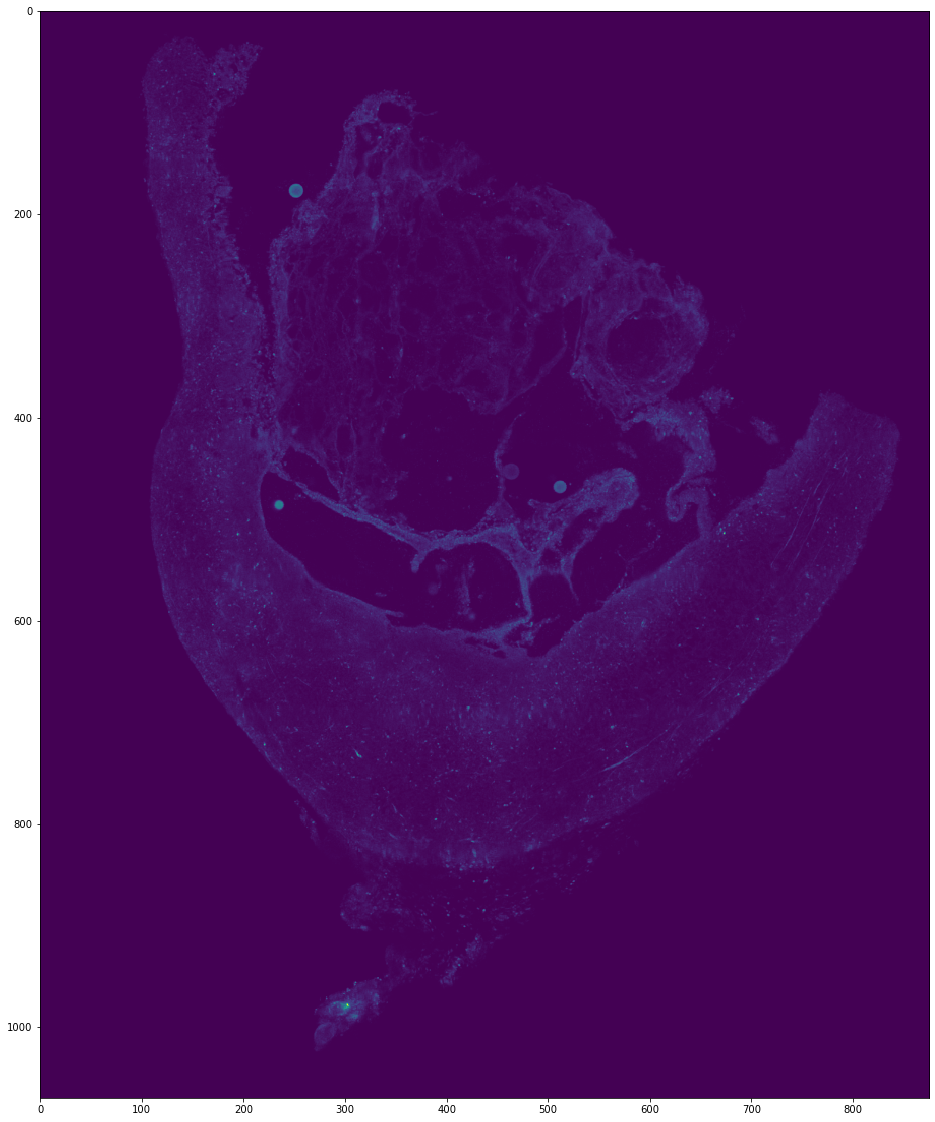

20210324_PDX_STG139_GFP_100x15um
/storage/processed/stpt/20210324_PDX_STG139_GFP_100x15um/mos
number_of_section 100
loading C3
volume_3_temp.shape (100, 2560, 2560)
start_y 0, start_z 0, size_y 2560, size_z 2560
aligning C3
cropping to 0-100,0-1529,0-1529
removing regions
cropping to 0-100,160-1482,208-1497


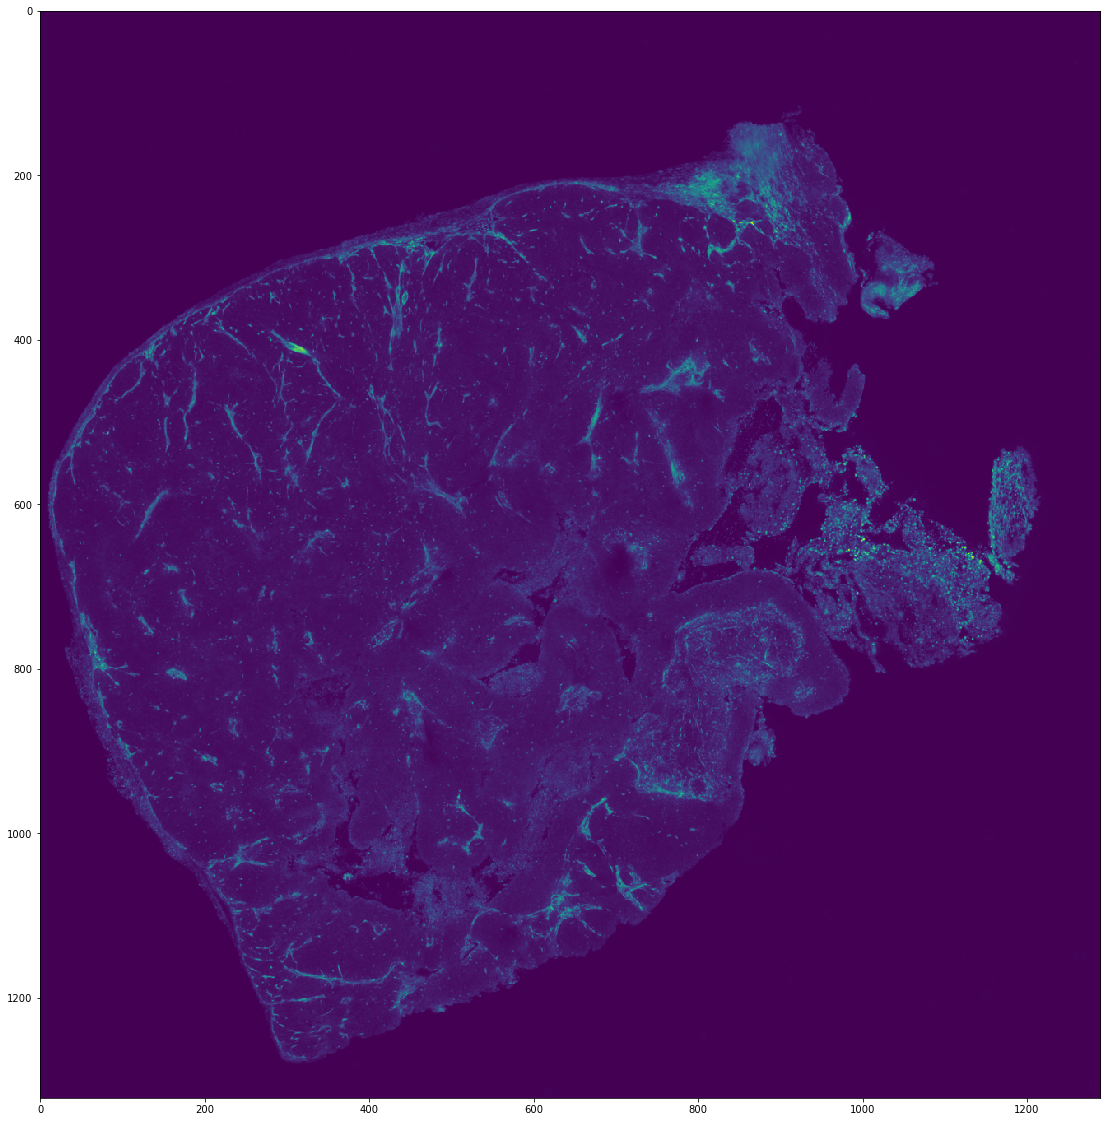

done


In [41]:
from IPython.display import clear_output
from matplotlib import pyplot as plt 
%matplotlib inline

from os.path import exists

for file_name, full_corner_half, cut_off_x_left, cut_off_x_right, cut_off_y_bottom, cut_off_y_top, angle, threshold_tissue, threshold_stroma, cut_off_bottom, cut_off_top in file_names_all:
    print(file_name)
    # zarr_file_name = "/storage/processed/stpt/" + file_name + "/mos.zarr"
    zarr_file_name = "/storage/processed/stpt/" + file_name + "/mos"
    old_method = False
    
    
    if not exists(zarr_file_name):
        zarr_file_name = "/data/meds1_c/storage/processed0/stpt/" + file_name + "/mos.zarr" # old
        old_method = True
    
    # if exists(zarr_file_name):
    if True:
        
        out_file_name = "../../../../storage/tristan/volumes/" + file_name + ".nii"
        
        if True:
        #if not exists(out_file_name):

            volume = Load(zarr_file_name, 7.5, old_method)
            volume = Crop(volume, threshold_tissue)
            volume = volume[cut_off_bottom: volume.shape[0] - cut_off_top, :,:]
            volume = RemoveSmallRegions(volume, threshold_tissue, 5000)
            volume = Crop(volume, threshold_tissue)
            
            #volume_itk = sitk.ReadImage(out_file_name, imageIO="MetaImageIO")
            #volume = sitk.GetArrayFromImage(volume_itk)
            #clear_output(wait=True)
            
            volume_itk = sitk.GetImageFromArray(volume)
            volume_itk.SetSpacing((7.5,7.5,15))
            
            sitk.WriteImage(volume_itk, out_file_name)

            plt.rcParams["figure.figsize"] = (20, 20) # (w, h)
            plt.imshow(volume[int(volume.shape[0]/2)], interpolation='nearest')
            plt.show()
            
print("done")

20211020_PDX_STG139_GFP_029621_100x15um
cropping to 0-78,1116-2074,1240-2223
0/78
1/78
2/78
3/78
4/78
5/78
6/78
7/78
8/78
9/78
10/78
11/78
12/78
13/78
14/78
15/78
16/78
17/78
18/78
19/78
20/78
21/78
22/78
23/78
24/78
25/78
26/78
27/78
28/78
29/78
30/78
31/78
32/78
33/78
34/78
35/78
36/78
37/78
38/78
39/78
40/78
41/78
42/78
43/78
44/78
45/78
46/78
47/78
48/78
49/78
50/78
51/78
52/78
53/78
54/78
55/78
56/78
57/78
58/78
59/78
60/78
61/78
62/78
63/78
64/78
65/78
66/78
67/78
68/78
69/78
70/78
71/78
72/78
73/78
74/78
75/78
76/78


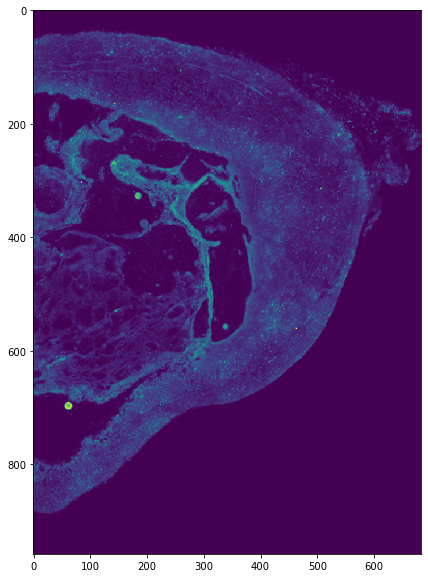

20210324_PDX_STG139_GFP_100x15um
cropping to 0-100,938-2224,1139-2175
0/100
1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100


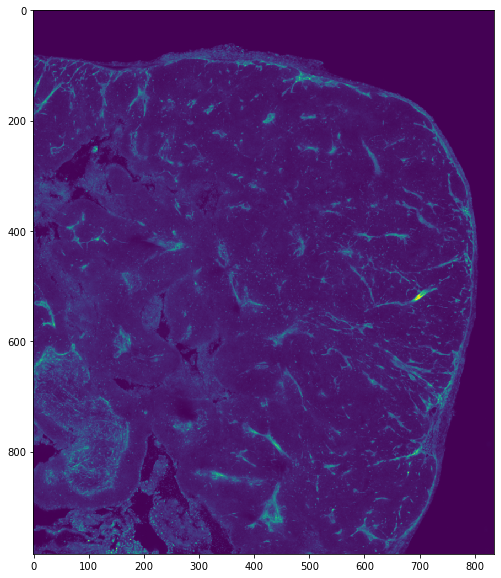

In [42]:


from IPython.display import clear_output
from matplotlib import pyplot as plt 
%matplotlib inline

import numpy as np
import math
import SimpleITK as sitk

from os.path import exists

for file_name, full_corner_half, cut_off_x_left, cut_off_x_right, cut_off_y_bottom, cut_off_y_top, angle, threshold_tissue, threshold_stroma, cut_off_bottom, cut_off_top in file_names_all:
    
    input_file_name = "../../../../storage/tristan/volumes/" + file_name + ".nii"
    out_file_name = "../../../../storage/tristan/processed/" + file_name + ".nii"
    print(file_name)
    
    volume_itk = sitk.ReadImage(input_file_name)
    volume = sitk.GetArrayFromImage(volume_itk)
    
    volume = np.pad(volume, ((0, 0), (1000, 1000), (1000, 1000)), mode='constant', constant_values=0)
    
    size2D = (int(volume.shape[2]), int(volume.shape[1]))
    z_size = volume.shape[0]
    
    for z in range(0, z_size):
        
        fixed = sitk.GetImageFromArray(volume[z,:,:])
        fixed.SetOrigin((0, 0))
        fixed.SetSpacing([7.5,7.5])

        transform = sitk.Euler2DTransform()
        center_X = int(volume.shape[1]/2)*7.5
        center_Y = int(volume.shape[2]/2)*7.5
        transform.SetCenter([center_X, center_Y])
        transform.SetAngle(angle * 3.14159265359/180)

        resampler = sitk.ResampleImageFilter()        
        resampler.SetSize(size2D)
        resampler.SetOutputSpacing([7.5,7.5])
        resampler.SetOutputOrigin((0, 0))
        resampler.SetInterpolator(sitk.sitkLinear)
        resampler.SetDefaultPixelValue(0)
        resampler.SetTransform(transform)

        out = resampler.Execute(fixed)
        
        np_out = sitk.GetArrayFromImage(out)
        volume[z,:,:] = np_out

    volume = Crop(volume, threshold_tissue) 
    volume = Upsample(volume, 7.5)
    volume = volume[:, cut_off_y_top:volume.shape[1]-cut_off_y_bottom, cut_off_x_left:volume.shape[2]-cut_off_x_right]
    # volume = RemoveSmallRegions(volume, threshold_tissue, 5000)
    
    volume_itk = sitk.GetImageFromArray(volume)
    volume_itk.SetSpacing((7.5,7.5,7.5))
    sitk.WriteImage(volume_itk, out_file_name)
    
    plt.rcParams["figure.figsize"] = (10, 10) # (w, h)
    plt.imshow(volume[int(volume.shape[0]/2)], interpolation='nearest')
    #plt.imshow(volume[0], interpolation='nearest')
    plt.show()
    
    